# CoDA — Split-Working Notebook (single-seed demo)
**What this notebook does:**
1) Uses your `util.py` and `spatial_environments.py` helpers.
2) Runs acquisition with **split-friendly** settings (no trace/retro decay during acquisition),
   then extinction with gentle forgetting (no hard reset).
3) Plots state graphs **only when they change**.
4) At the end, renders the **final learned** representation vs **ground-truth** for acquisition and extinction.

**Why this should split again (compared to your recent version):**
- Acquisition uses `trace_decay=1.0` and `retro_decay=1.0` so prospective/retrospective evidence accumulates.
- Conservative—but not too strict—split gates: `theta_split=0.9`, `confidence=0.90`,
  and lower exposure/presence thresholds (`min_effective_exposure=12`, `min_presence_episodes=6`, `n_threshold=6`).
- Credit assignment boosted: `lam=0.9`, `gamma=0.95`.
- No cloning of terminals; reuse existing clones; structural merge retained for extinction.

In [1]:

import sys, numpy as np
sys.path.append('/mnt/data')

from spatial_environments import GridEnvRightDownNoSelf, GridEnvRightDownNoCue
from util import generate_dataset, generate_dataset_post_augmentation


## CoDA Agent (embedded)
This matches the uncertainty-aware split/merge you iterated on, with acquisition-friendly defaults.

In [2]:

from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Set
import numpy as np

# --- small helpers ---
def _ensure_shape_3d(arr: np.ndarray, new_shape: Tuple[int,int,int]) -> np.ndarray:
    if arr is None:
        return np.zeros(new_shape, dtype=float)
    S_old, A_old, S2_old = arr.shape
    S, A, S2 = new_shape
    out = np.zeros(new_shape, dtype=float)
    out[:S_old, :A_old, :S2_old] = arr
    return out

def normalize_transition_counts(counts: np.ndarray, eps: float=1e-12) -> np.ndarray:
    probs = counts.astype(float, copy=True)
    denom = probs.sum(axis=2, keepdims=True)
    denom[denom < eps] = 1.0
    probs /= denom
    return probs

def get_action_successors_from_counts(counts: np.ndarray, s: int, a: int):
    if counts.size == 0:
        return []
    succ_mask = counts[s, a] > 0
    return list(np.where(succ_mask)[0])

# --- uncertainty helpers ---
try:
    from mpmath import betainc, erfcinv
    _HAS_MPMATH = True
except Exception:
    _HAS_MPMATH = False

def posterior_prob_p_greater_than(theta: float, success: float, failure: float, alpha0: float=0.5, beta0: float=0.5) -> float:
    if not _HAS_MPMATH:
        return 0.0
    a = alpha0 + max(0.0, float(success))
    b = beta0 + max(0.0, float(failure))
    cdf = betainc(a, b, 0, theta, regularized=True)
    return float(1.0 - cdf)

def wilson_lower_bound(phat: float, n: float, confidence: float=0.95) -> float:
    if n <= 0:
        return 0.0
    if _HAS_MPMATH:
        z = float((2.0**0.5) * erfcinv(2*(1.0-confidence)))
    else:
        z = 1.6448536269514722  # ~95%
    denom = 1.0 + (z*z)/n
    center = phat + (z*z)/(2.0*n)
    adj = z * ((phat*(1.0-phat) + (z*z)/(4.0*n))/n)**0.5
    return (center - adj)/denom

# --- interface to your util traces ---
from util import compute_eligibility_traces, accumulate_conditioned_eligibility_traces

@dataclass
class CoDAConfig:
    gamma: float = 0.95
    lam: float = 0.9
    theta_split: float = 0.9
    theta_merge: float = 0.5
    n_threshold: int = 6
    eps: float = 1e-9
    min_presence_episodes: int = 6
    min_effective_exposure: float = 12.0
    confidence: float = 0.90
    alpha0: float = 0.5
    beta0: float = 0.5
    # forgetting knobs
    count_decay: float = 0.995
    trace_decay: float = 1.0   # <-- no forgetting in acquisition
    retro_decay: float = 1.0   # <-- no forgetting in acquisition

@dataclass
class CoDAAgent:
    env: GridEnvRightDownNoSelf
    cfg: CoDAConfig = field(default_factory=CoDAConfig)

    n_actions: int = field(init=False)
    n_states: int = field(init=False)
    transition_counts: np.ndarray = field(init=False)
    transition_probs: np.ndarray = field(init=False)

    E_r: np.ndarray = field(init=False)
    E_nr: np.ndarray = field(init=False)
    C: np.ndarray = field(init=False)

    cs_us_presence: np.ndarray = field(init=False)
    us_episode_ema: float = field(default=0.0, init=False)
    presence_episodes: np.ndarray = field(init=False)

    salient_cues: Set[int] = field(default_factory=set, init=False)
    cue_to_clones: Dict[int, List[int]] = field(default_factory=dict, init=False)
    clone_parent: Dict[int, int] = field(default_factory=dict, init=False)
    created_by_cue: Dict[int, int] = field(default_factory=dict, init=False)

    def __post_init__(self):
        all_actions = set()
        for s, acts in self.env.valid_actions.items():
            for a in acts:
                all_actions.add(a)
        self.n_actions = max(all_actions) + 1 if all_actions else 0
        self.n_states = int(self.env.num_unique_states)

        self.transition_counts = np.zeros((self.n_states, self.n_actions, self.n_states), dtype=float)
        self.transition_probs = normalize_transition_counts(self.transition_counts)

        self.E_r  = np.zeros((1, self.n_states))
        self.E_nr = np.zeros((1, self.n_states))
        self.C    = np.zeros((1, self.n_states))
        self.cs_us_presence = np.zeros((1, self.n_states))
        self.presence_episodes = np.zeros((1, self.n_states))

    def _maybe_grow(self, needed_state_index: int):
        if needed_state_index < self.n_states:
            return
        new_n = needed_state_index + 1
        self.transition_counts = _ensure_shape_3d(self.transition_counts, (new_n, self.n_actions, new_n))
        self.transition_probs = normalize_transition_counts(self.transition_counts)
        pad = ((0,0),(0,new_n - self.E_r.shape[1]))
        self.E_r  = np.pad(self.E_r,  pad, mode='constant')
        self.E_nr = np.pad(self.E_nr, pad, mode='constant')
        self.C    = np.pad(self.C,    pad, mode='constant')
        self.cs_us_presence = np.pad(self.cs_us_presence, pad, mode='constant')
        self.presence_episodes = np.pad(self.presence_episodes, pad, mode='constant')
        self.n_states = new_n

    def update_with_episode(self, states: List[int], actions: List[int]):
        # decay counts (mild) to iron-out sampling noise but not block splitting
        if self.cfg.count_decay < 1.0:
            self.transition_counts *= self.cfg.count_decay

        # decay prospective accumulators
        if self.cfg.trace_decay < 1.0:
            self.E_r  *= self.cfg.trace_decay
            self.E_nr *= self.cfg.trace_decay
            self.C    *= self.cfg.trace_decay

        # decay retrospective accumulators and denominator
        if self.cfg.retro_decay < 1.0:
            self.cs_us_presence *= self.cfg.retro_decay
            self.us_episode_ema *= self.cfg.retro_decay

        max_id = max(states) if states else 0
        self._maybe_grow(max_id)

        for t in range(len(actions)):
            s  = states[t]
            a  = actions[t]
            sp = states[t+1]
            self._maybe_grow(max(s, sp))
            self.transition_counts[s, a, sp] += 1.0

        rewarded_terminal  = self.env.rewarded_terminals[0]  if len(self.env.rewarded_terminals)>0   else None
        unrewarded_terminal= self.env.unrewarded_terminals[0] if len(self.env.unrewarded_terminals)>0 else None
        self.E_r, self.E_nr, self.C = accumulate_conditioned_eligibility_traces(
            self.E_r, self.E_nr, self.C,
            states,
            sprime=rewarded_terminal,
            sprime2=unrewarded_terminal,
            n_states=self.n_states,
            lam=self.cfg.lam,
            gamma=self.cfg.gamma
        )

        _, ep_counts = compute_eligibility_traces(states, self.n_states, gamma=self.cfg.gamma, lam=self.cfg.lam)
        presence = (ep_counts[-1,:] > 0).astype(float)[None, :]

        if states[-1] == rewarded_terminal:
            self.us_episode_ema += 1.0
            self.cs_us_presence[:, :presence.shape[1]] += presence

        self.presence_episodes[:, :presence.shape[1]] += presence
        self.transition_probs = normalize_transition_counts(self.transition_counts)

    def prospective(self) -> np.ndarray:
        num = self.E_r.copy()
        den = self.E_r + self.E_nr + self.cfg.eps
        return (num / den).reshape(-1)

    def retrospective(self) -> np.ndarray:
        if self.us_episode_ema <= self.cfg.eps:
            return np.zeros(self.n_states)
        return (self.cs_us_presence / float(self.us_episode_ema)).reshape(-1)

    def maybe_split(self) -> List[int]:
        pc = self.prospective()
        new_cues = []
        exposure = (self.E_r + self.E_nr).reshape(-1)

        for s in range(self.n_states):
            if s in self.env.rewarded_terminals or s in self.env.unrewarded_terminals:
                continue
            if self.C[0, s] < self.cfg.n_threshold:
                continue
            if self.presence_episodes[0, s] < self.cfg.min_presence_episodes:
                continue
            if exposure[s] < self.cfg.min_effective_exposure:
                continue
            if s in self.salient_cues:
                continue

            post_prob = posterior_prob_p_greater_than(self.cfg.theta_split, self.E_r[0, s], self.E_nr[0, s],
                                                      self.cfg.alpha0, self.cfg.beta0)
            if post_prob == 0.0:
                lb = wilson_lower_bound(pc[s], max(exposure[s], 1e-9), confidence=self.cfg.confidence)
                pass_test = (lb > self.cfg.theta_split)
            else:
                pass_test = (post_prob >= self.cfg.confidence)

            if pass_test:
                clones = self._split_state(s)
                if clones:
                    self.salient_cues.add(s)
                    self.cue_to_clones[s] = list(clones)
                    new_cues.append(s)
        return new_cues

    def _split_state(self, s: int) -> List[int]:
        """Clone successors of state s and re-route s->s' to s->clone(s').
           Do not clone terminals; never clone a clone; reuse existing clones."""
        clones: List[int] = []
        terminals = set(self.env.rewarded_terminals) | set(self.env.unrewarded_terminals)
        seen_successors = set()

        for a in range(self.n_actions):
            s_primes = get_action_successors_from_counts(self.transition_counts, s, a)
            for sprime in s_primes:
                if sprime in seen_successors:
                    continue
                seen_successors.add(sprime)

                if sprime in terminals:
                    continue

                if sprime in self.clone_parent:
                    target = sprime
                else:
                    target = self.env.reverse_clone_dict.get(sprime, None)
                    if target is None:
                        clone_id = self.n_states
                        self._maybe_grow(clone_id)

                        self.env.add_clone_dict(clone_id, successor=sprime)
                        self.env.add_reverse_clone_dict(new_clone=clone_id, successor=sprime)

                        self.clone_parent[clone_id] = sprime
                        self.created_by_cue[clone_id] = s
                        clones.append(clone_id)

                        self.transition_counts[clone_id, :, :] = self.transition_counts[sprime, :, :]
                        target = clone_id

                cnt = self.transition_counts[s, a, sprime]
                if cnt > 0:
                    self.transition_counts[s, a, sprime] = 0.0
                    self.transition_counts[s, a, target] += cnt

        self.transition_probs = normalize_transition_counts(self.transition_counts)
        return clones

    def maybe_merge(self) -> List[int]:
        """Merge when informativeness falls or clone edges are unused."""
        pc = self.prospective()
        rc = self.retrospective()
        merged: List[int] = []
        edge_eps = getattr(self, "_edge_eps_override", 1e-6)

        for cue in list(self.salient_cues):
            info = pc[cue] * rc[cue]

            clone_ids = self.cue_to_clones.get(cue, [])
            edge_mass = 0.0
            if clone_ids:
                for a in range(self.n_actions):
                    for cl in clone_ids:
                        if cl < self.transition_probs.shape[2]:
                            edge_mass += float(self.transition_probs[cue, a, cl])

            if (info < self.cfg.theta_merge) or (edge_mass < edge_eps):
                self._merge_cue(cue)
                self.salient_cues.remove(cue)
                self.cue_to_clones.pop(cue, None)
                merged.append(cue)

        self.transition_probs = normalize_transition_counts(self.transition_counts)
        return merged

    def _merge_cue(self, cue: int):
        clones = self.cue_to_clones.get(cue, [])
        for clone_id in clones:
            if clone_id >= self.n_states or clone_id not in self.clone_parent:
                continue
            sprime = self.clone_parent[clone_id]
            for a in range(self.n_actions):
                cnt = self.transition_counts[cue, a, clone_id]
                if cnt > 0:
                    self.transition_counts[cue, a, clone_id] = 0.0
                    self.transition_counts[cue, a, sprime] += cnt
            inbound = self.transition_counts[:, :, clone_id]
            if inbound.sum() > 0:
                self.transition_counts[:, :, sprime] += inbound
                self.transition_counts[:, :, clone_id] = 0.0
            self.transition_counts[clone_id, :, :] = 0.0
            if clone_id in self.env.clone_dict:
                self.env.clone_dict.pop(clone_id, None)
        new_rev = {}
        for cl, par in self.env.clone_dict.items():
            new_rev[par] = cl
        self.env.reverse_clone_dict = new_rev

    def get_T(self) -> np.ndarray:
        return self.transition_probs

    def get_PC_RC(self):
        return self.prospective(), self.retrospective()


## Change-aware plotting helpers (graphs only when changed)

In [3]:

import numpy as np

THRESH = 0.30  # keep consistent with env.plot_graph threshold

def make_terminals_absorbing_for_plot(T, terminals):
    T = T.copy()
    for t in terminals:
        if t < T.shape[0]:
            T[t, :, :] = 0.0
    return T

def sanitize_for_plot(env, T, eps=1e-12):
    if T is None or getattr(T, "ndim", 0) != 3:
        return
    S = T.shape[0]
    out_mass = T.sum(axis=(1, 2))
    in_mass  = T.sum(axis=(0, 1))
    active = (out_mass + in_mass) > eps
    for cl in list(getattr(env, "clone_dict", {}).keys()):
        if cl >= S or not active[cl]:
            env.clone_dict.pop(cl, None)
    env.reverse_clone_dict = {parent: cl for cl, parent in env.clone_dict.items()}

def thresh_adj(T, thr=THRESH):
    A = T.sum(axis=1)  # [S,S]
    return (A >= thr).astype(np.uint8)

def clone_dict_tuple(d):
    return tuple(sorted(d.items())) if isinstance(d, dict) else tuple()

def graph_changed(prev_T, prev_map, curr_T, curr_map, thr=THRESH):
    if curr_T is None:
        return False
    if prev_T is None:
        return True
    if prev_T.shape != curr_T.shape:
        return True
    A_prev = thresh_adj(prev_T, thr)
    A_curr = thresh_adj(curr_T, thr)
    if A_prev.shape != A_curr.shape:
        return True
    if (A_prev != A_curr).any():
        return True
    return prev_map != curr_map


## Run acquisition (split-friendly)

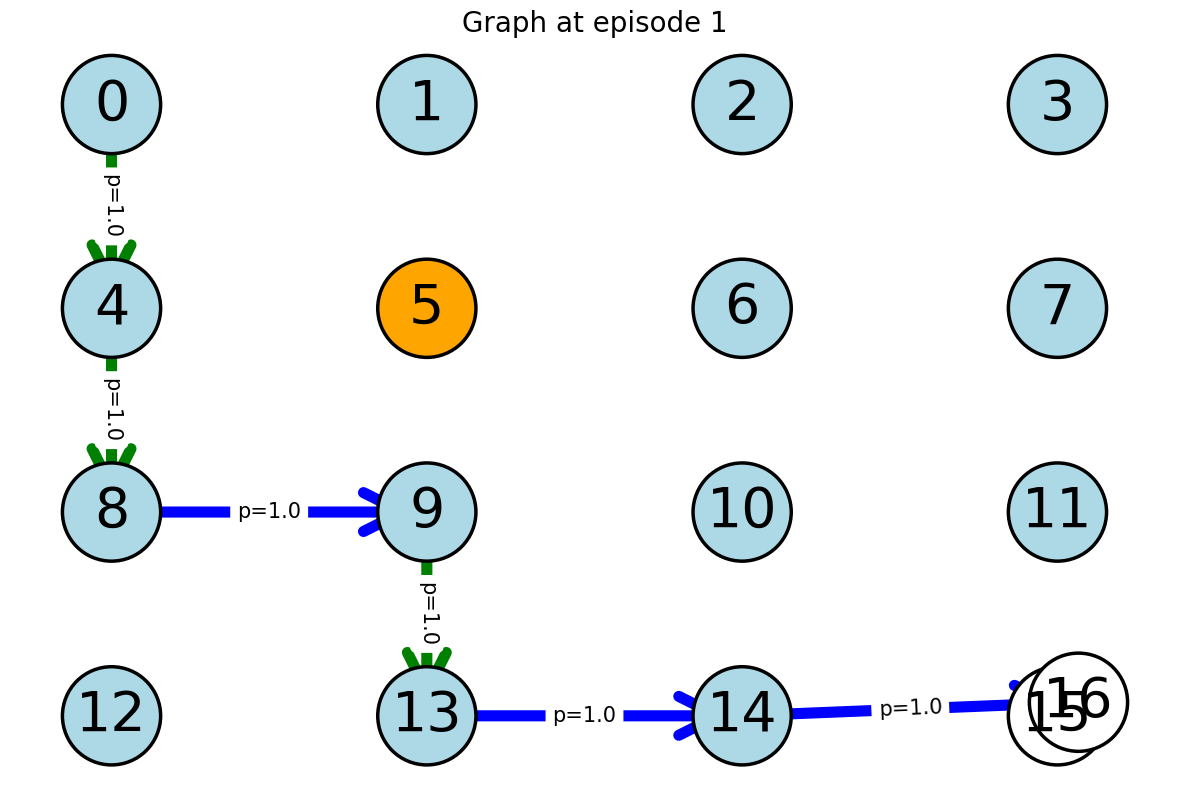

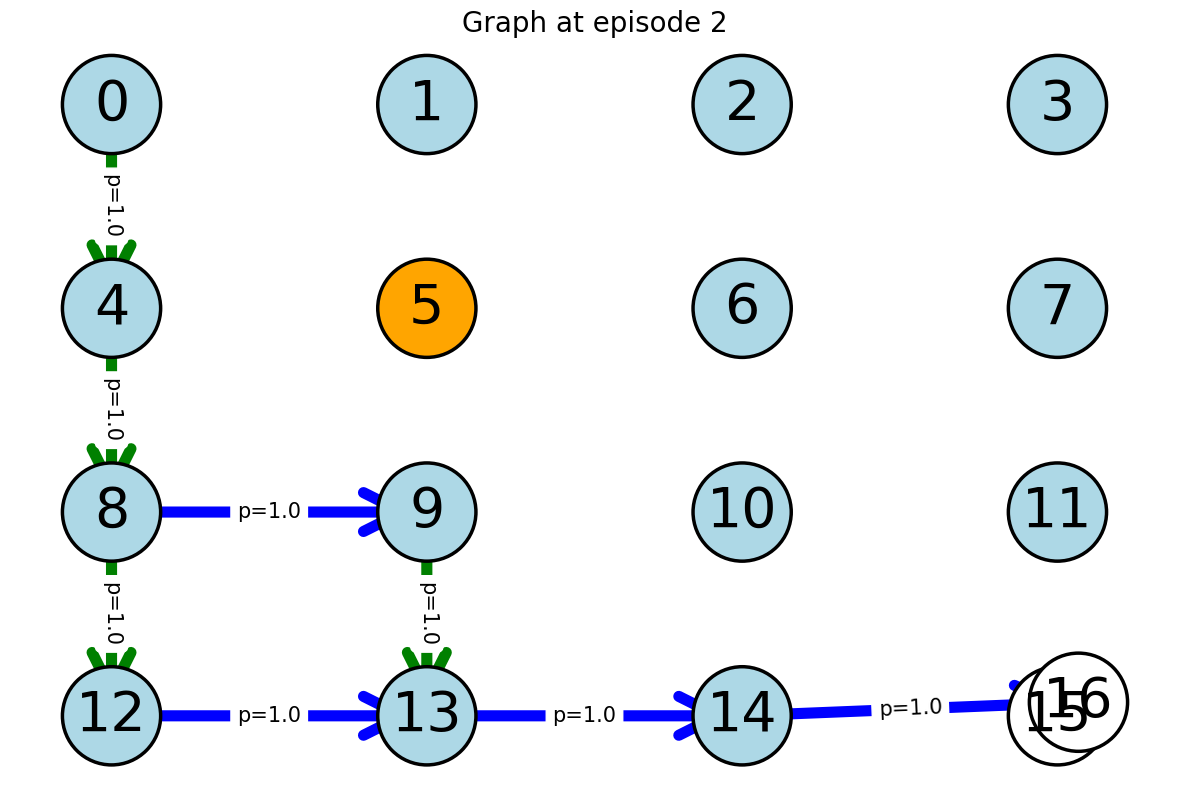

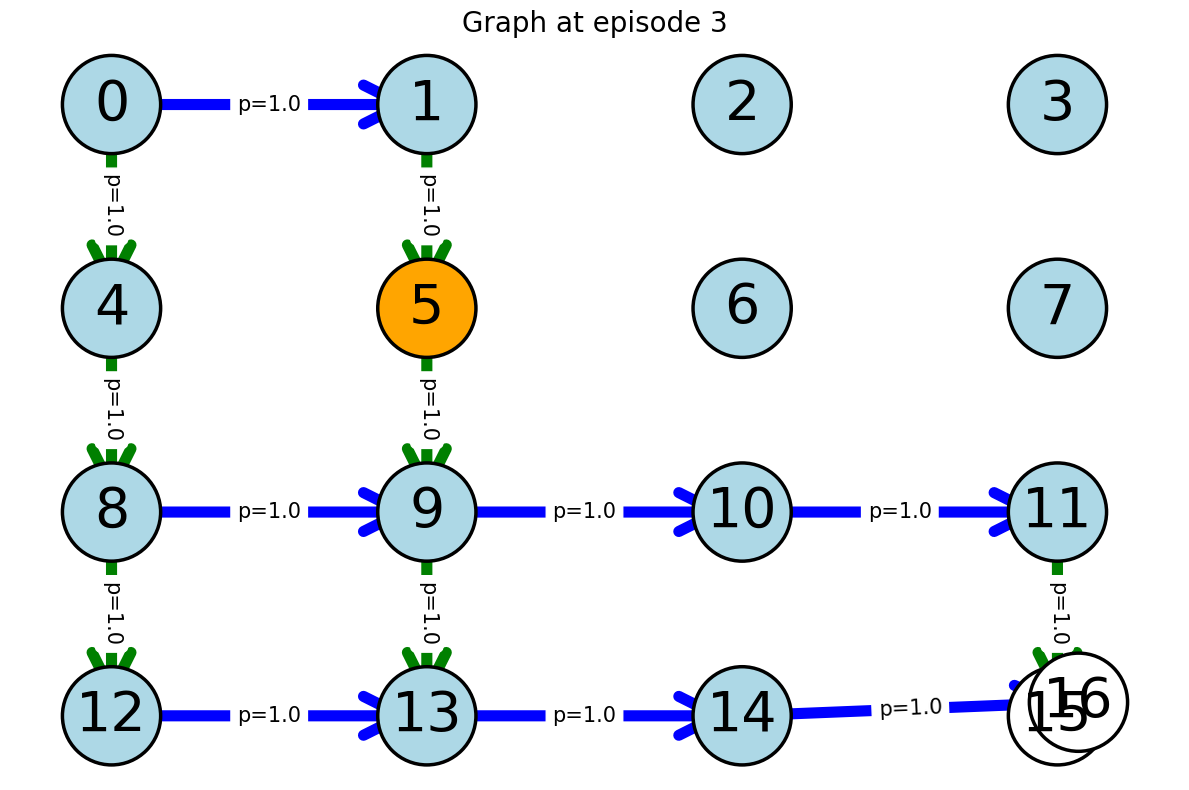

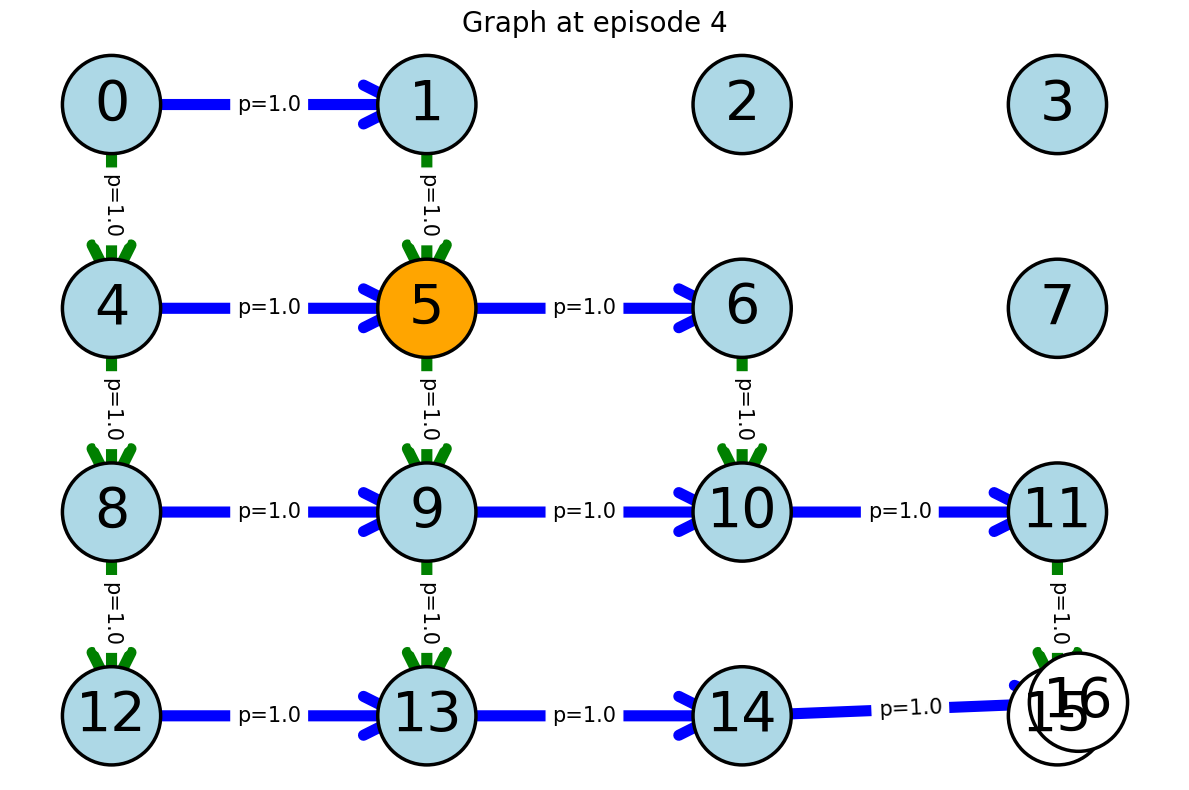

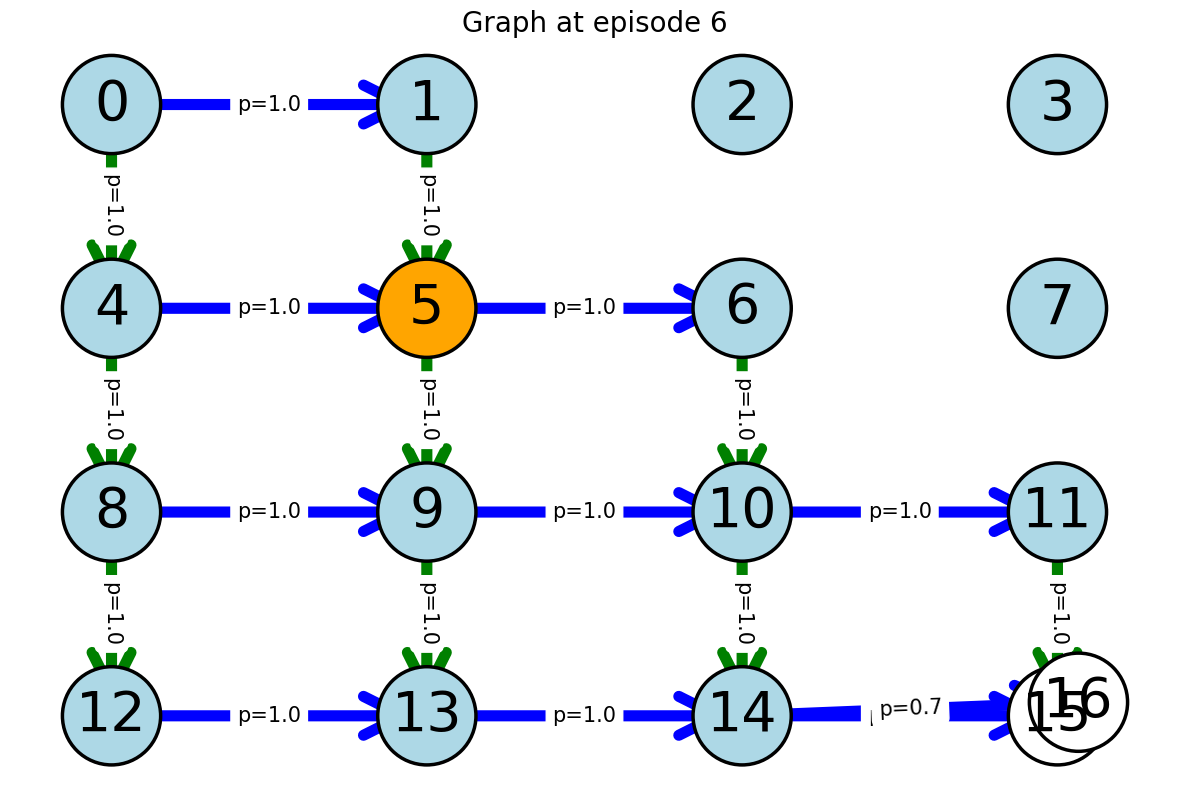

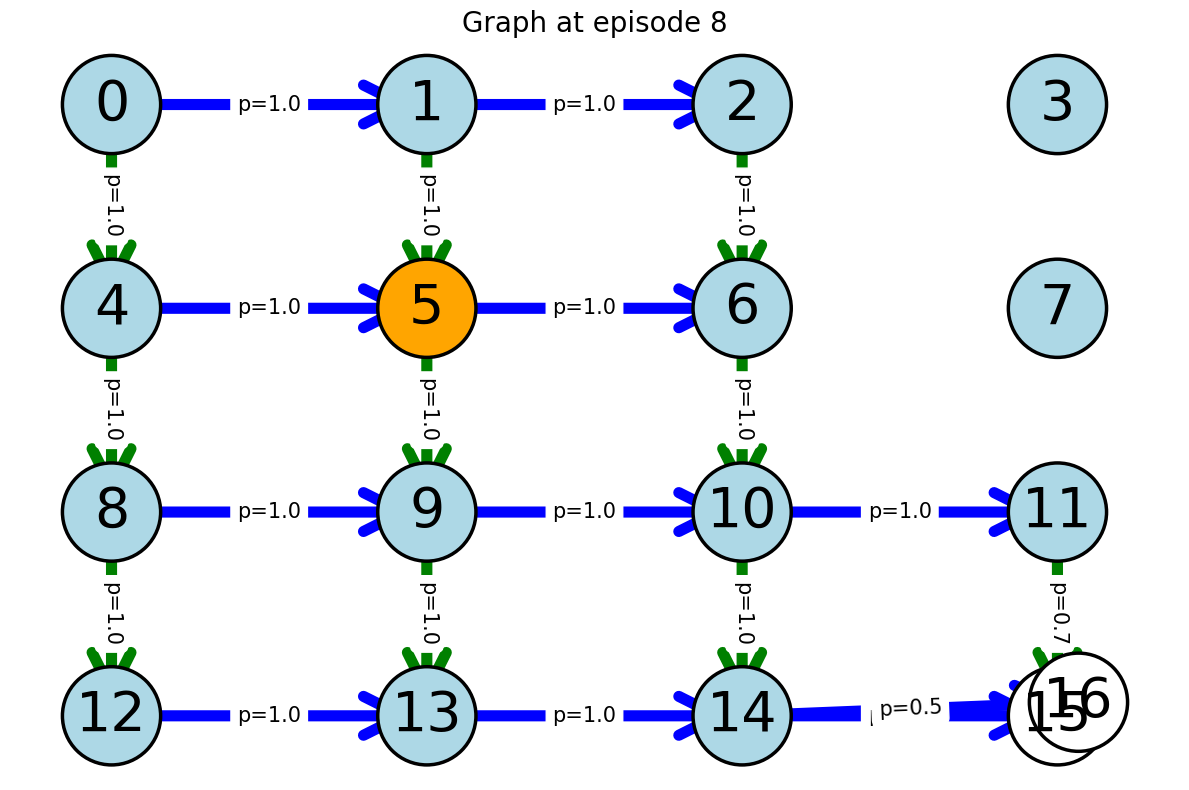

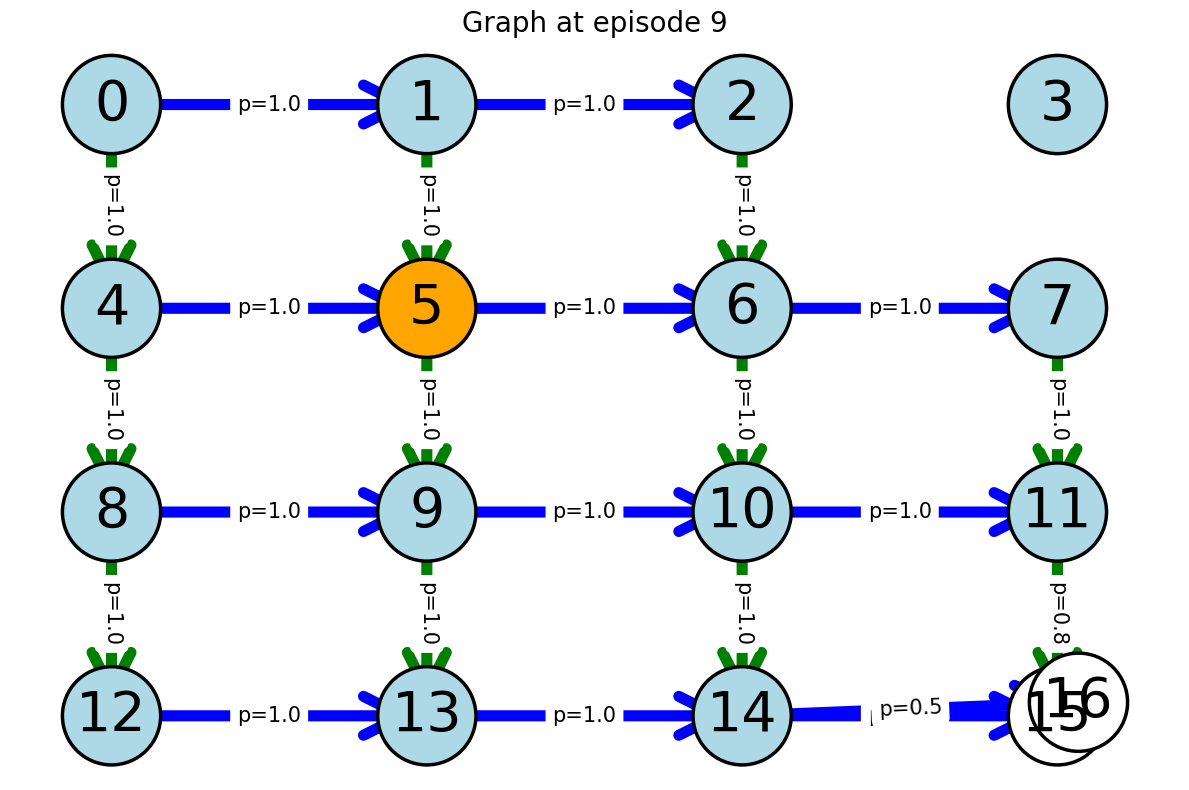

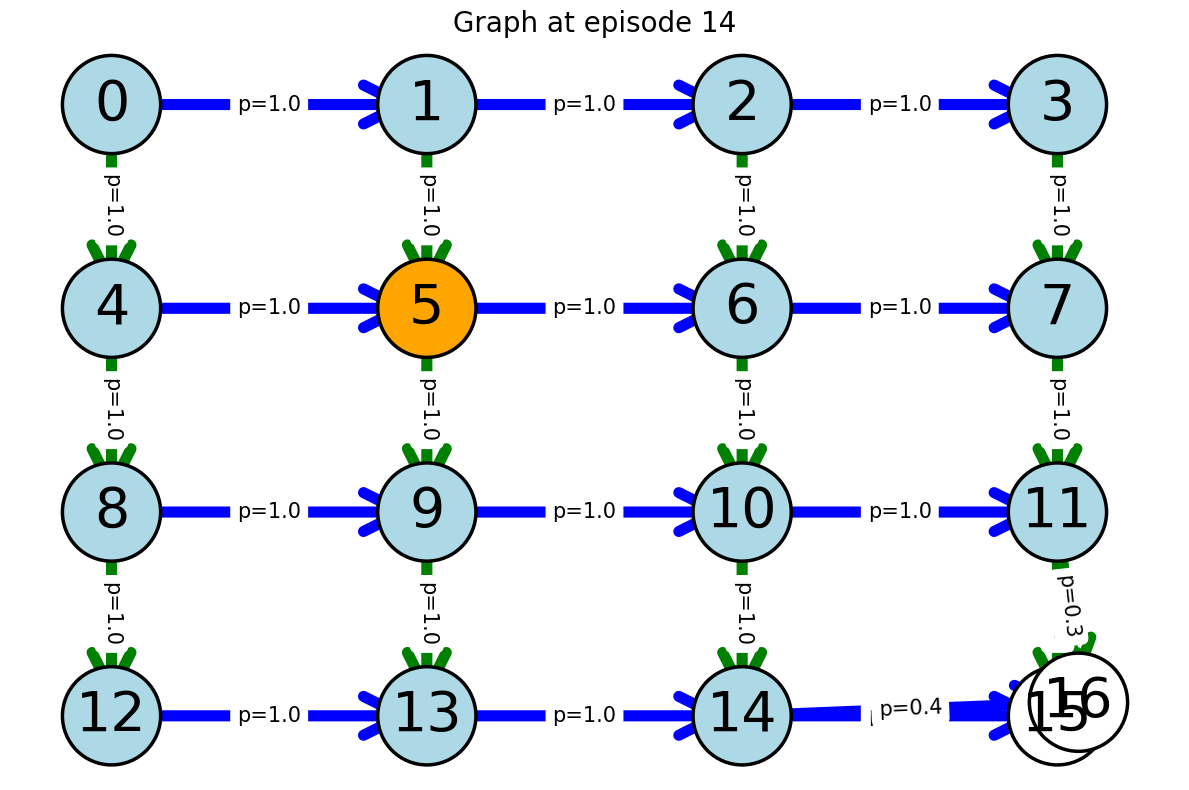

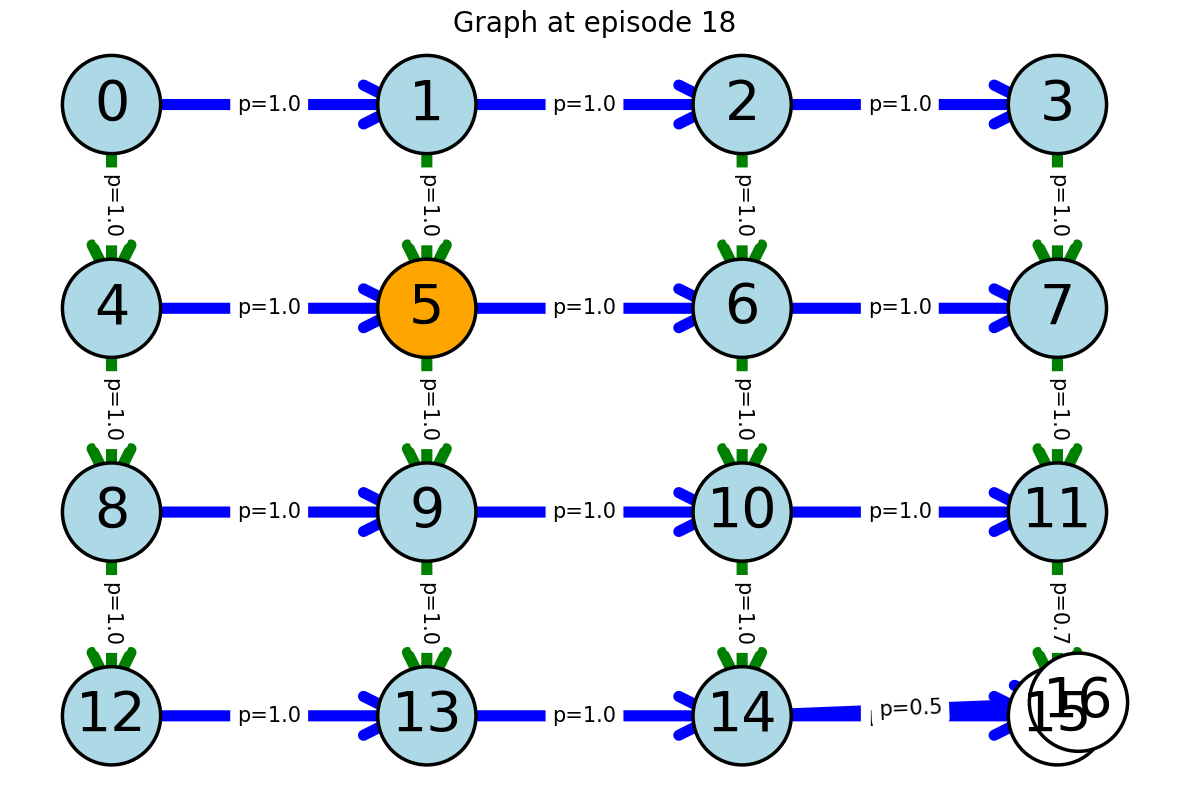

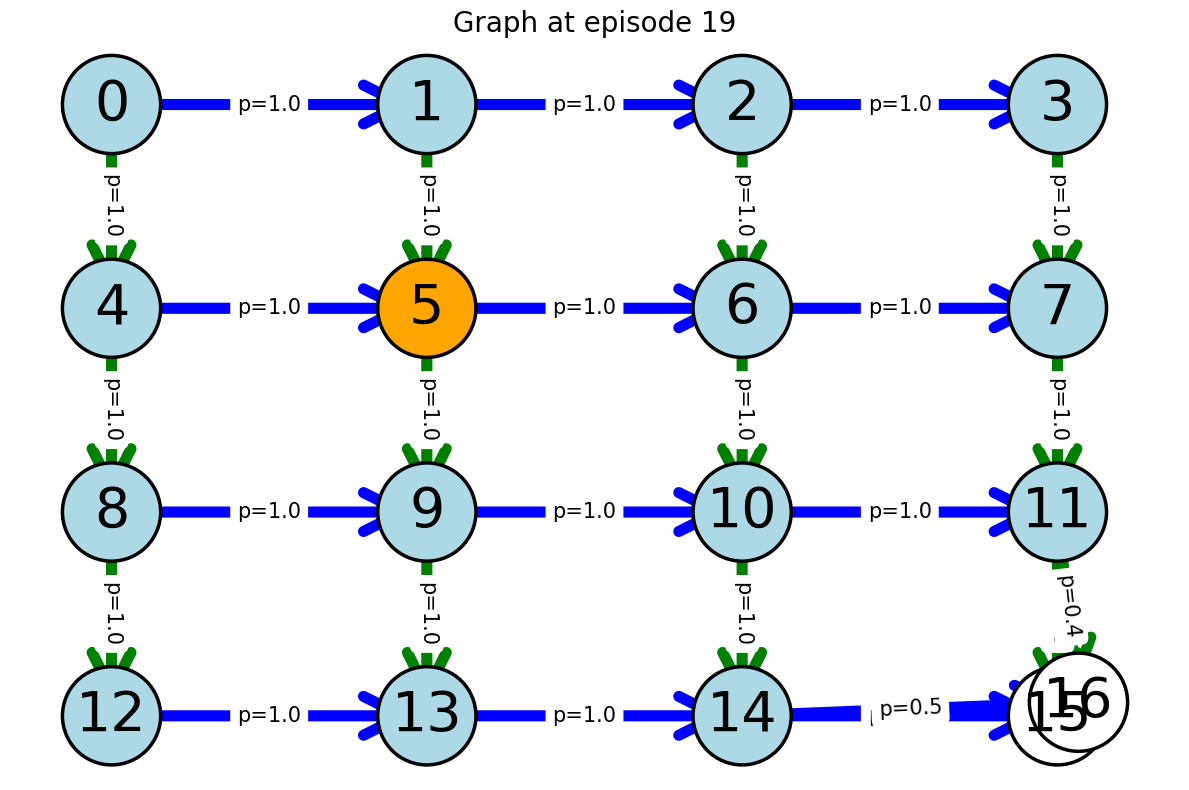

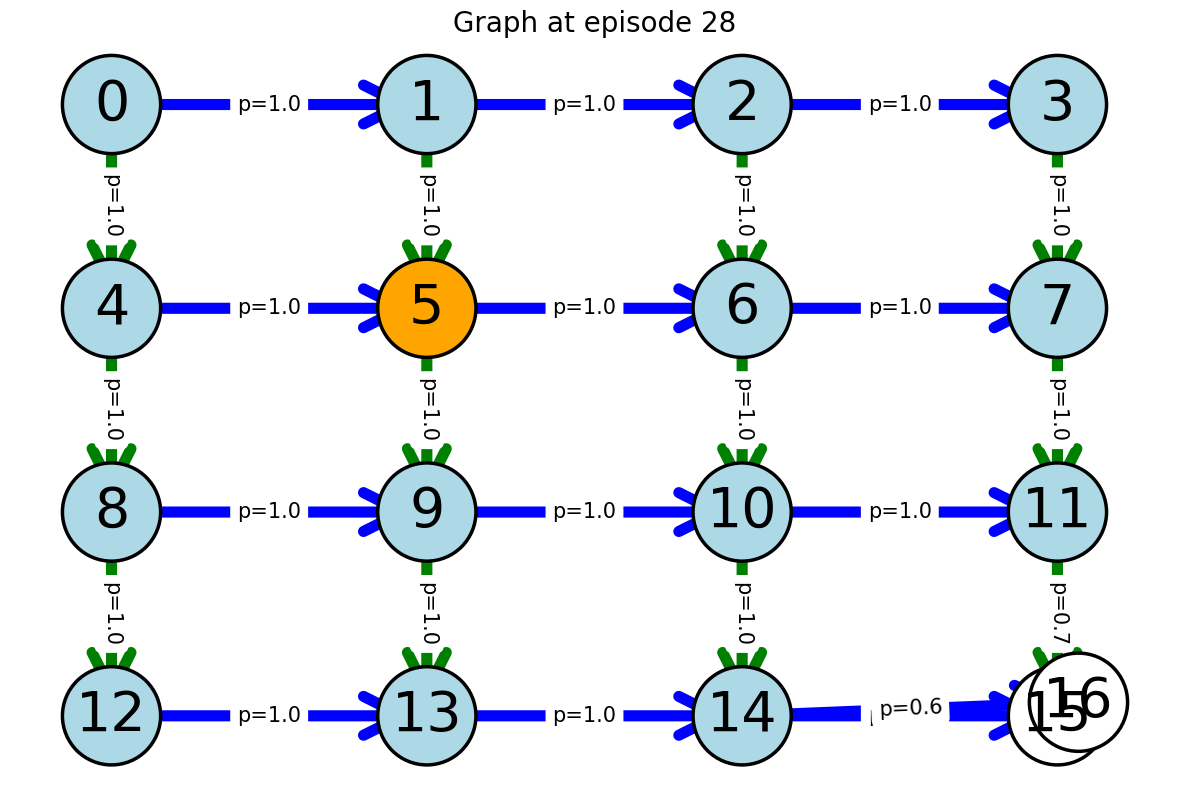

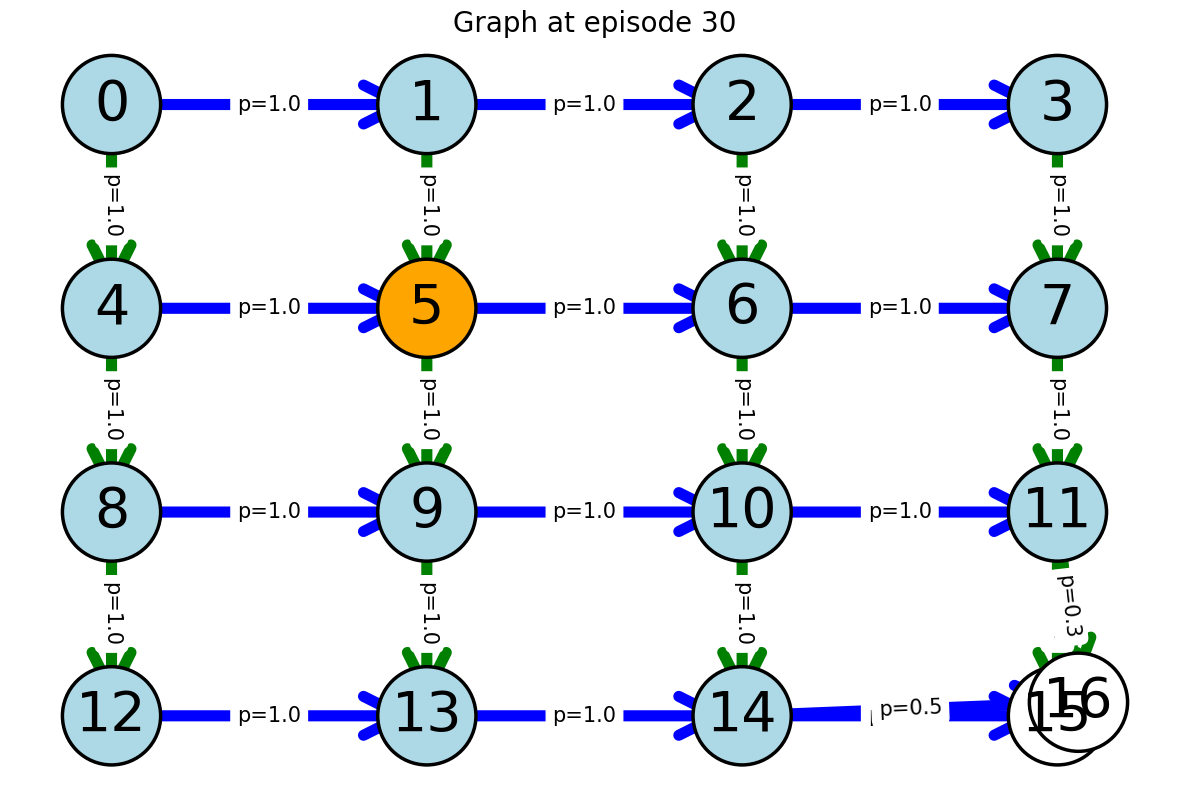

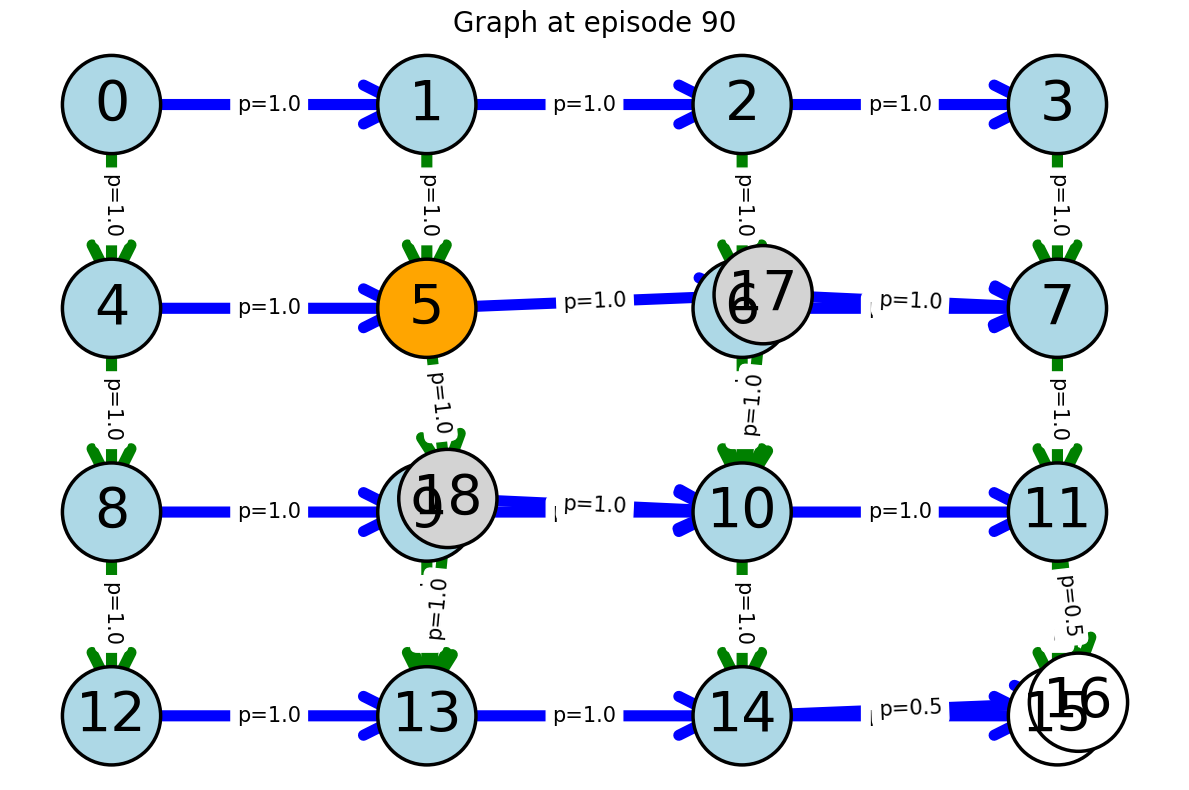

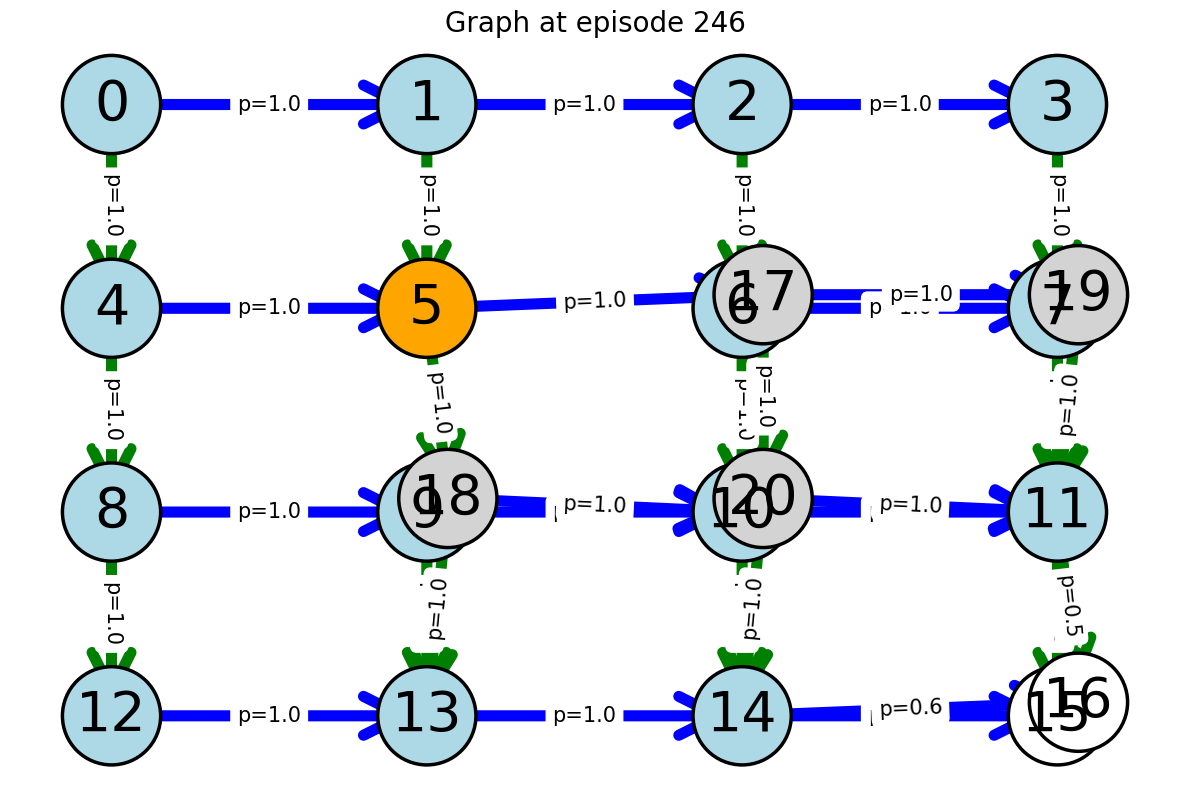

Changed episodes (acquisition): [1, 2, 3, 4, 6, 8, 9, 14, 18, 19, 28, 30, 90, 246] ... total: 14


In [4]:

# --- knobs ---
SEED      = 11
N_ACQ     = 250
N_EXT     = 300
MAX_STEPS = 20
CUE       = 5

np.random.seed(SEED)

# --- env & agent ---
env = GridEnvRightDownNoSelf(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
agent = CoDAAgent(env)  # acquisition-friendly defaults baked into CoDAConfig

# --- acquisition loop with change-aware plotting ---
with_clones = False
prev_T = None
prev_map = None
changed_acq = []

for ep in range(1, N_ACQ+1):
    if with_clones:
        (states, actions) = generate_dataset_post_augmentation(env, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
    else:
        (states, actions) = generate_dataset(env, n_episodes=1, max_steps=MAX_STEPS)[0]

    agent.update_with_episode(states, actions)
    if agent.maybe_split():
        with_clones = True

    T_curr   = agent.get_T().copy()
    map_curr = clone_dict_tuple(getattr(env, "clone_dict", {}))

    if graph_changed(prev_T, prev_map, T_curr, map_curr, thr=THRESH):
        T_vis = make_terminals_absorbing_for_plot(T_curr, env.rewarded_terminals + env.unrewarded_terminals)
        sanitize_for_plot(env, T_vis)
        env.plot_graph(T_vis, niter=ep, threshold=THRESH, save=False, savename=f"graph_ep{ep}.png")
        changed_acq.append(ep)
        prev_T, prev_map = T_curr, map_curr

print("Changed episodes (acquisition):", changed_acq[:15], "... total:", len(changed_acq))
T_acq_final = agent.get_T().copy()


## Switch to extinction (no reset, gentle forgetting + decisive merges)

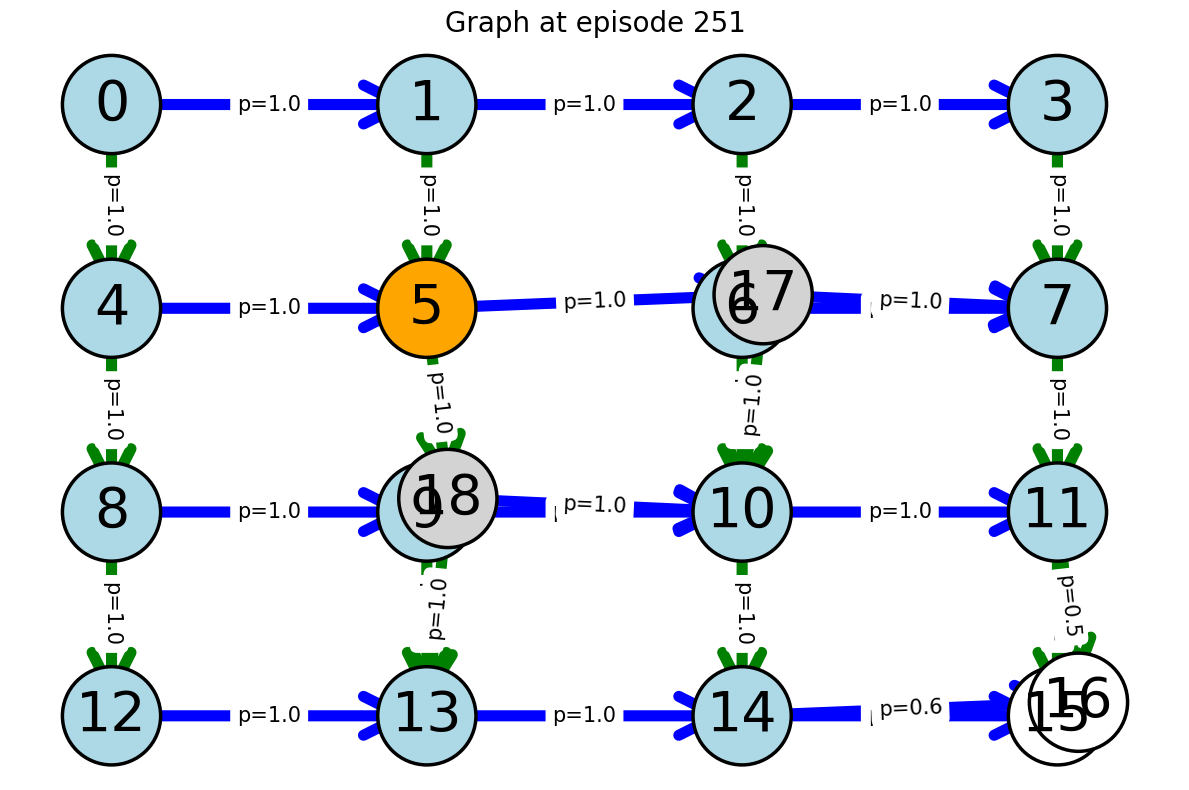

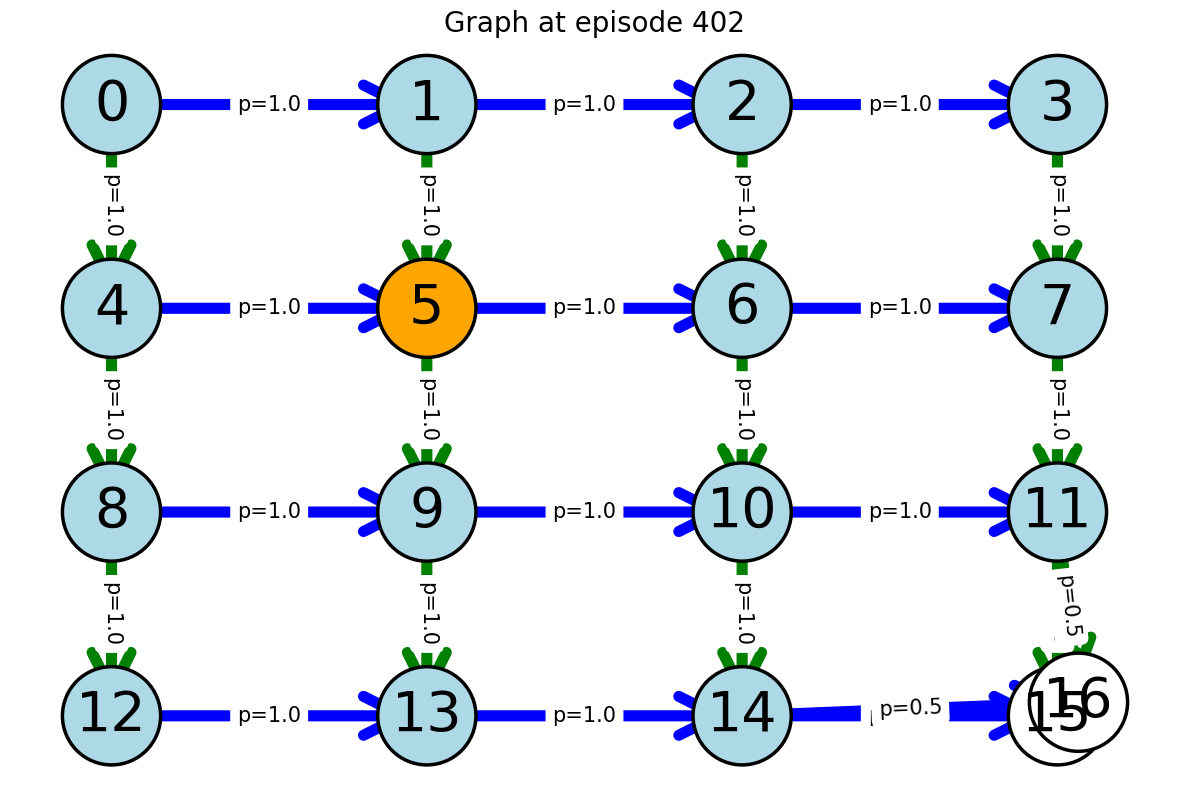

Changed episodes (extinction): [251, 402] ... total: 2


In [5]:

# extinction env
env2 = GridEnvRightDownNoCue(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
env2.clone_dict = dict(getattr(env, "clone_dict", {}))
env2.reverse_clone_dict = dict(getattr(env, "reverse_clone_dict", {}))
agent.env = env2

# extinction schedule (no hard reset): stronger forgetting for first 50 eps, stronger merge, stricter split
WASH_IN = 50
orig = dict(count_decay=agent.cfg.count_decay, trace_decay=agent.cfg.trace_decay, retro_decay=agent.cfg.retro_decay,
            theta_merge=agent.cfg.theta_merge, confidence=agent.cfg.confidence,
            min_presence_episodes=agent.cfg.min_presence_episodes, min_effective_exposure=agent.cfg.min_effective_exposure)

agent.cfg.count_decay          = 0.98
agent.cfg.trace_decay          = 0.98
agent.cfg.retro_decay          = 0.98
agent.cfg.theta_merge          = 0.60
agent.cfg.confidence           = 0.99
agent.cfg.min_presence_episodes += 3
agent.cfg.min_effective_exposure = int(agent.cfg.min_effective_exposure * 1.5)

EDGE_EPS_EARLY = 1e-4
EDGE_EPS_LATE  = 1e-6

# extinction loop with change-aware plotting
prev_T = prev_T
prev_map = prev_map
changed_ext = []

for k, ep in enumerate(range(N_ACQ+1, N_ACQ+N_EXT+1)):
    (states, actions) = generate_dataset_post_augmentation(env2, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
    agent.update_with_episode(states, actions)

    # structural cutoff scheduling
    agent._edge_eps_override = EDGE_EPS_EARLY if k < WASH_IN else EDGE_EPS_LATE
    agent.maybe_merge()

    T_curr   = agent.get_T().copy()
    map_curr = clone_dict_tuple(getattr(env2, "clone_dict", {}))

    if graph_changed(prev_T, prev_map, T_curr, map_curr, thr=THRESH):
        T_vis = make_terminals_absorbing_for_plot(T_curr, env2.rewarded_terminals + env2.unrewarded_terminals)
        sanitize_for_plot(env2, T_vis)
        env2.plot_graph(T_vis, niter=ep, threshold=THRESH, save=False, savename=f"graph_ep{ep}.png")
        changed_ext.append(ep)
        prev_T, prev_map = T_curr, map_curr

    # restore knobs after wash-in window
    if k == WASH_IN-1:
        agent.cfg.count_decay           = orig["count_decay"]
        agent.cfg.trace_decay           = orig["trace_decay"]
        agent.cfg.retro_decay           = orig["retro_decay"]
        agent.cfg.theta_merge           = orig["theta_merge"]
        agent.cfg.confidence            = orig["confidence"]
        agent.cfg.min_presence_episodes = orig["min_presence_episodes"]
        agent.cfg.min_effective_exposure= orig["min_effective_exposure"]

print("Changed episodes (extinction):", changed_ext[:15], "... total:", len(changed_ext))
T_ext_final = agent.get_T().copy()


## Final learned vs ground-truth (for this seed)

Final learned (acq)


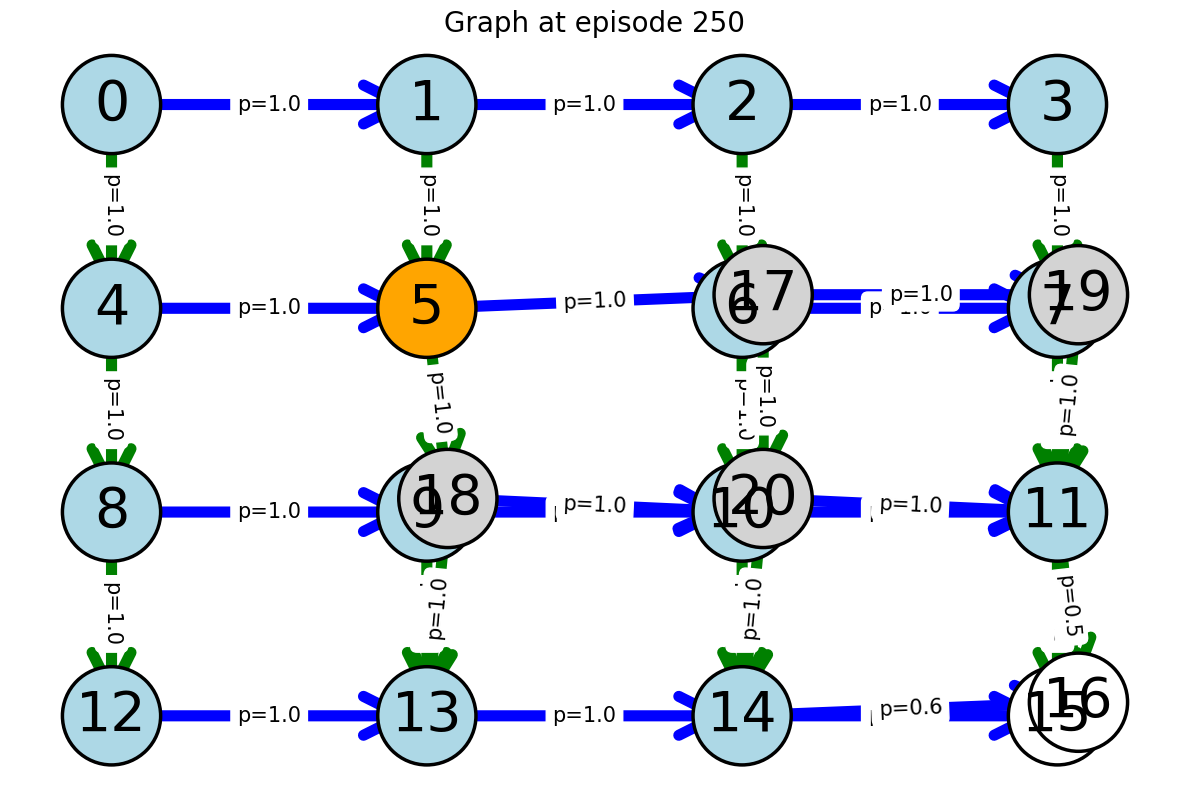

Ground-truth (acq)


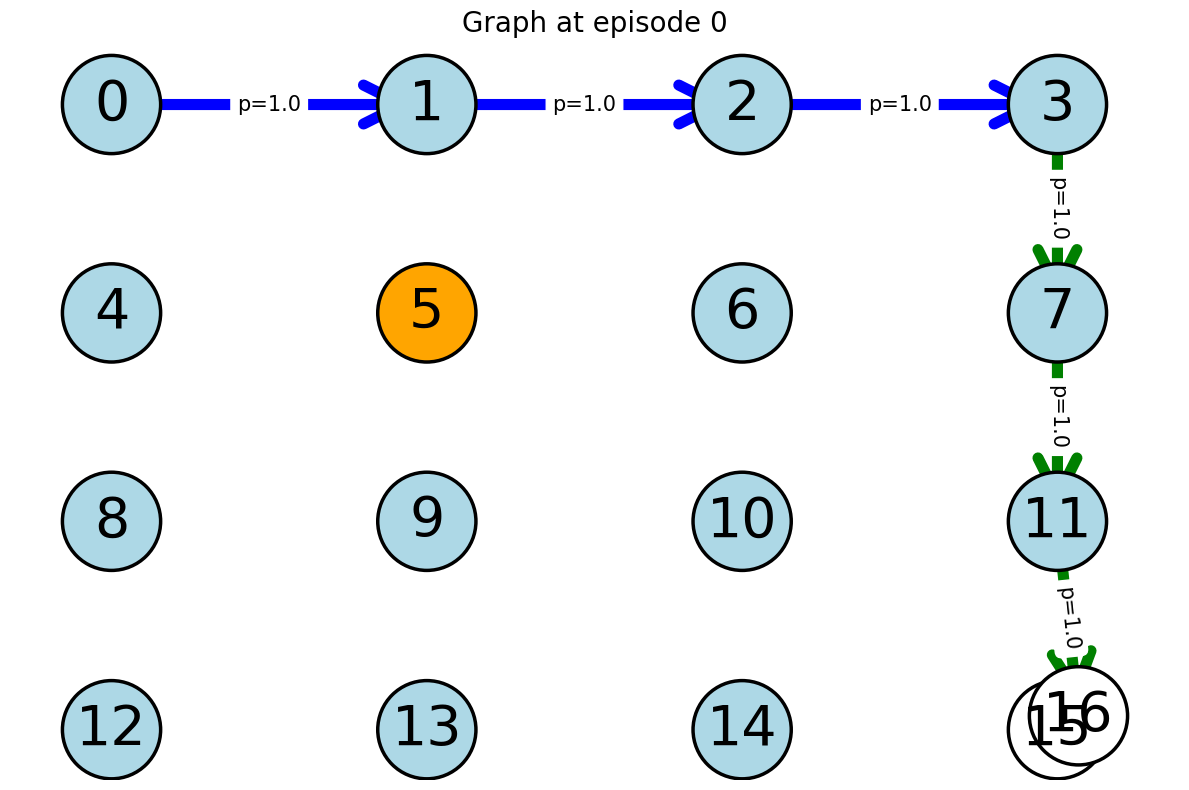

Final learned (ext)


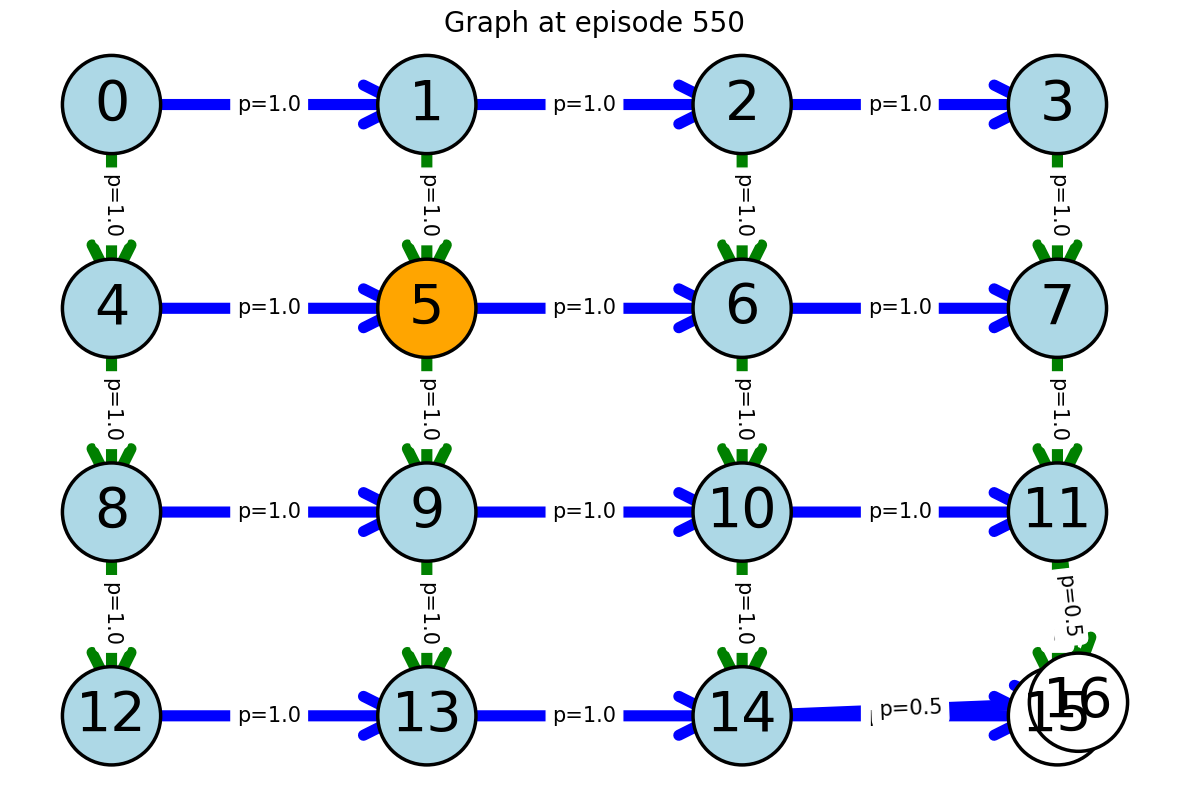

Ground-truth (ext)


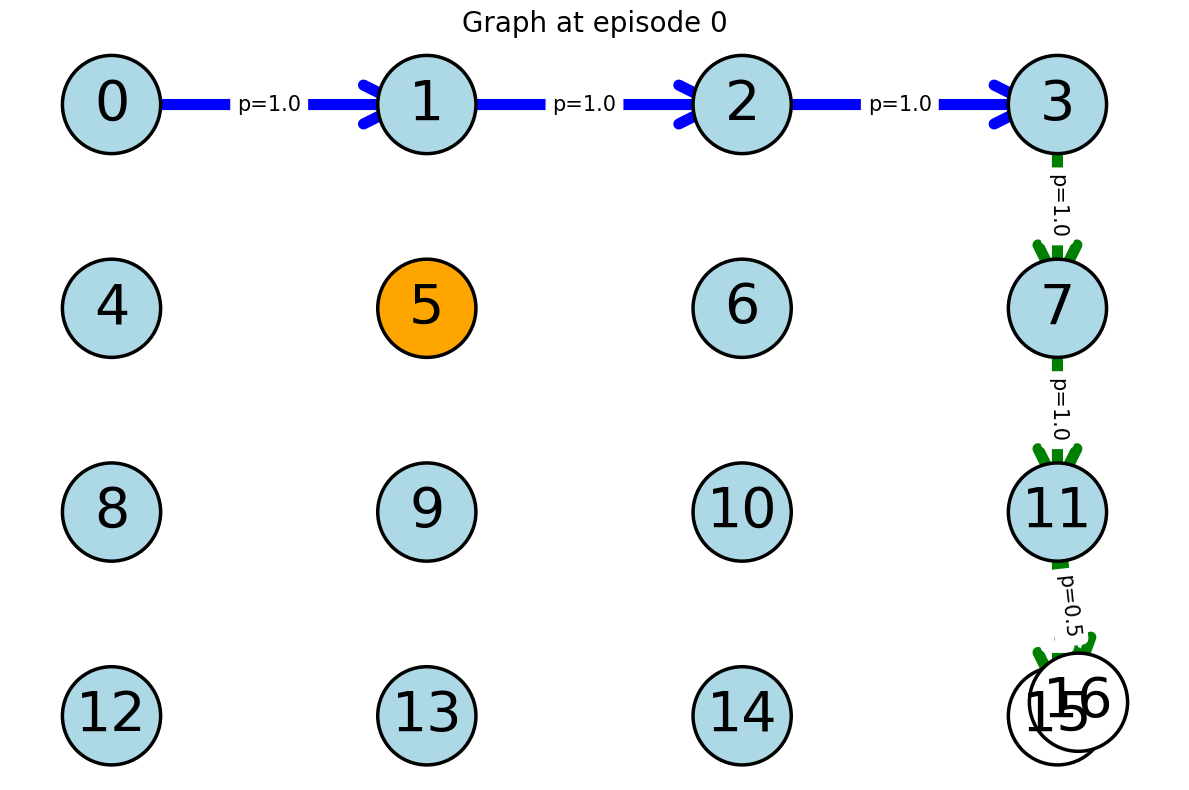

In [6]:

from coda_metrics import ref_empirical_from_rollouts, greedy_right_down_policy

def _pad3(A, shape):
    S,A_,S2 = A.shape
    Sg,Ag,S2g = shape
    out = np.zeros(shape, dtype=float)
    out[:min(S,Sg), :min(A_,Ag), :min(S2,S2g)] = A[:min(S,Sg), :min(A_,Ag), :min(S2,S2g)]
    return out

# build fixed references for clean comparison
T_ref_acq = ref_empirical_from_rollouts(env,  greedy_right_down_policy, n_episodes=2000, max_steps=MAX_STEPS)
T_ref_ext = ref_empirical_from_rollouts(env2, greedy_right_down_policy, n_episodes=2000, max_steps=MAX_STEPS)

shape1 = tuple(max(x,y) for x,y in zip(T_acq_final.shape, T_ref_acq.shape))
shape2 = tuple(max(x,y) for x,y in zip(T_ext_final.shape, T_ref_ext.shape))

T_acq_vis = make_terminals_absorbing_for_plot(_pad3(T_acq_final, shape1), env.rewarded_terminals + env.unrewarded_terminals)
T_ref_acq_vis = make_terminals_absorbing_for_plot(_pad3(T_ref_acq, shape1), env.rewarded_terminals + env.unrewarded_terminals)

T_ext_vis = make_terminals_absorbing_for_plot(_pad3(T_ext_final, shape2), env2.rewarded_terminals + env2.unrewarded_terminals)
T_ref_ext_vis = make_terminals_absorbing_for_plot(_pad3(T_ref_ext, shape2), env2.rewarded_terminals + env2.unrewarded_terminals)

# learned final maps
sanitize_for_plot(env, T_acq_vis)
sanitize_for_plot(env2, T_ext_vis)

print("Final learned (acq)")
env.plot_graph(T_acq_vis, niter=N_ACQ, threshold=THRESH, save=False, savename=f"final_acq_learned.png")
print("Ground-truth (acq)")
env.plot_graph(T_ref_acq_vis, niter=0, threshold=THRESH, save=False, savename=f"final_acq_groundtruth.png")

print("Final learned (ext)")
env2.plot_graph(T_ext_vis, niter=N_ACQ+N_EXT, threshold=THRESH, save=False, savename=f"final_ext_learned.png")
print("Ground-truth (ext)")
env2.plot_graph(T_ref_ext_vis, niter=0, threshold=THRESH, save=False, savename=f"final_ext_groundtruth.png")
